# Complaint / Incident Data Exploration

### Summary
This Jupyter notebook performs preliminary exploratory analysis of the relationship between fire safety-related complaints and fire incidents.

### Preliminary Findings
At the EAS level, there appears to be a fairly significant negative relationship between the number of fire safety complaints issued at a certain location, and the incident of a fire at any point between 2006-2016.  This could be because addressing fire safety complaints actually works as a preemptive measure to avoid a fire incident.

However, these are very preliminary findings and it could be that results change significantly when we filter out some of the types of complaints (like "uncategorized complaint") or subset the data in other ways.

### Reccomendations
Consider using the number of fire safety complaints (or, more simply, a safety complaints dummy) at a given EAS location as a predictor in the model.  We could also modify this variable to filter out "uncategorized" complaints or complaints found to be without merit.

## Data preperation
For now, I am keeping the complaint and incident data simple.  Both datasets are subset to 2006-2016, and I am only considering building fire/cooking fire/trash fire incidents for analysis. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import statsmodels.api as sm
import patsy

%matplotlib inline

#Read in data
path = 'C:\\Users\\Kevin\\Desktop\\Fire Risk\\Model_matched_to_EAS'
complaint_df = pd.read_csv(path + '\\' + 'matched_Fire_Safety_Complaints.csv', 
              low_memory=False)
incident_df = pd.read_csv(path + '\\' + 'matched_Fire_Incidents.csv', 
              low_memory=False)

#Functions
def topcom(data, strvar):
    t = pd.DataFrame(data.groupby(strvar)[strvar].count().sort_values(ascending=False))
    t.rename(columns = {strvar: 'Count'}, inplace=True)
    t[strvar] = t.index
    return t

def my_barplot(xaxis, yaxis, dta, title):
    g1 = sns.barplot(x=xaxis, y=yaxis, data=dta, palette='coolwarm_r')
    g1.set_xticklabels(labels=dta[xaxis], rotation=90)
    g1.set_title(title)
    sns.despine()
    return g1

#Subset complaint data, keep only 2006-2016 to maintain comparability
complaint_df = complaint_df[['Complaint Item Type Description',
               'Received Date',
               'Disposition',
               'Neighborhood  District',  #Note two spaces b/w words
               'Closest Address',
               'EAS']].dropna(subset=['EAS'])  #Drop where EAS nan
           
complaint_df = complaint_df[(complaint_df['Received Date'] >= '2006-01-01') & 
              (complaint_df['Received Date'] <= '2016-12-31')]

               
#Subset fire incident data, keep only 2006-2016 to maintain comparability            
#Also, keep only building fire/cooking fire/trash fire                                    
incident_df = incident_df[['Incident Date',
                           'Closest Address',
                           'Primary Situation',
                           'Neighborhood  District',  #Note two spaces b/w words
                           'Property Use',
                           'EAS']].dropna(subset=['EAS'])  #Drop where EAS nan

incident_df.rename(columns = {'Primary Situation': 'Situation'}, inplace=True)

incident_df = incident_df[(incident_df.Situation.str.contains("111")) |
                          (incident_df.Situation.str.contains("113")) |
                          (incident_df.Situation.str.contains("118")) |
                          (incident_df.Situation.str.contains("150")) |
                          (incident_df.Situation.str.contains("151")) |
                          (incident_df.Situation.str.contains("154"))]

incident_df['Situation'] = incident_df['Situation'].str.replace('111 building fire', '111 - building fire')
incident_df['Situation'] = incident_df['Situation'].str.replace('113 cooking fire, confined to container', '113 - cooking fire, confined to container')
incident_df['Situation'] = incident_df['Situation'].str.replace('118 trash or rubbish fire, contained', '118 - trash or rubbish fire, contained')
incident_df['Situation'] = incident_df['Situation'].str.replace('150 outside rubbish fire, other', '150 - outside rubbish fire, other')
incident_df['Situation'] = incident_df['Situation'].str.replace('151 outside rubbish, trash or waste fire', '151 - outside rubbish, trash or waste fire')
incident_df['Situation'] = incident_df['Situation'].str.replace('154 dumpster or other outside trash receptacle fire', '154 - dumpster/outside trash receptacle fire')
                          
incident_df = incident_df[(incident_df['Incident Date'] >= '2006-01-01') & 
              (incident_df['Incident Date'] <= '2016-12-31')]

## Types of complaints and fire incidents

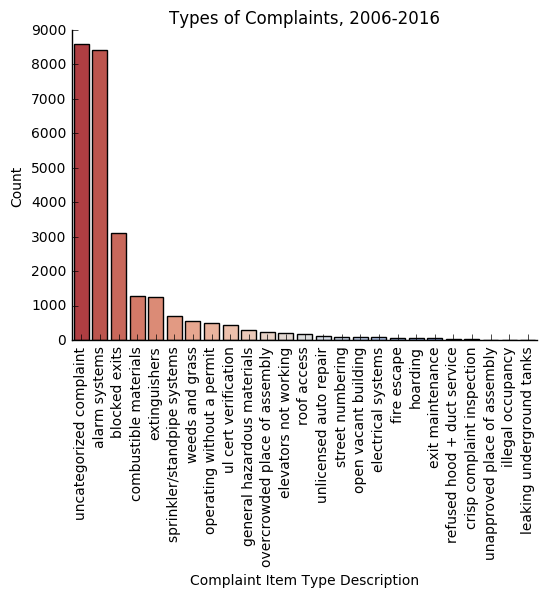

In [12]:
#Types of complaints
temp = topcom(complaint_df, 'Complaint Item Type Description')
my_barplot('Complaint Item Type Description', 'Count', temp , 'Types of Complaints, 2006-2016')

The most prevelant type of complaint in the data is "uncategorized", which is not very helpful.  However, other prevelant complaints such as alarm systems (not functioning?) and combustible materials would appear to pose a fire risk.  

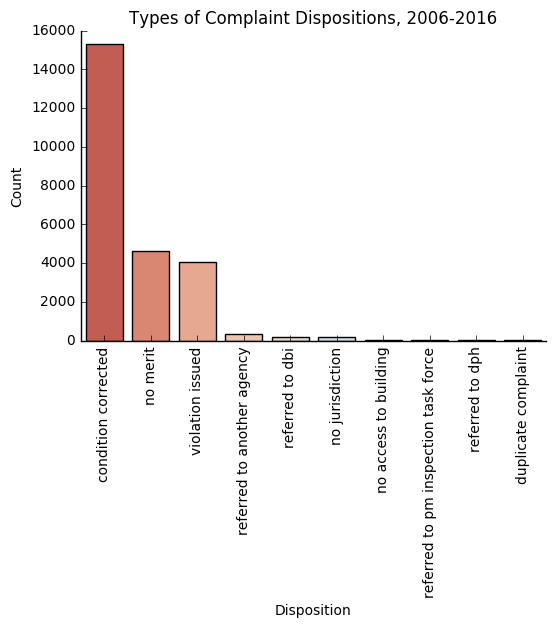

In [3]:
#Dispositions
temp = topcom(complaint_df, 'Disposition')
my_barplot('Disposition', 'Count', temp, 'Types of Complaint Dispositions, 2006-2016')

One aspect of the complaints data to consider (if we end up using this) is the "dispositions" variable.  For example, would we want to include complaints that have "no merit" in our model?  (Probably not...)

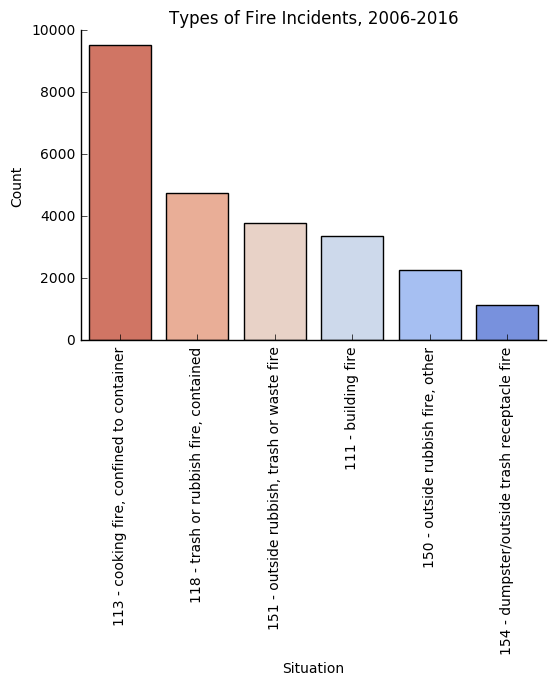

In [4]:
#Types of fire incidents (remember we removed a few of these)
temp = topcom(incident_df, 'Situation')
my_barplot('Situation', 'Count', temp, 'Types of Fire Incidents, 2006-2016')

## Relationship between complaints and fire incidents (at neighborhood level)
Aggregating the data at the neighborhood level would imply that there is a strong positive relationship between the number of complaints between 2006-2016 and the total number of (subset) fire incidents. However, there could be a number of collinear factors.  For example, complaints and incidents could both be correlated with neighborhood population, density, or per capita income.  Lets see what happens when we try to analyze the relationship at the EAS level...


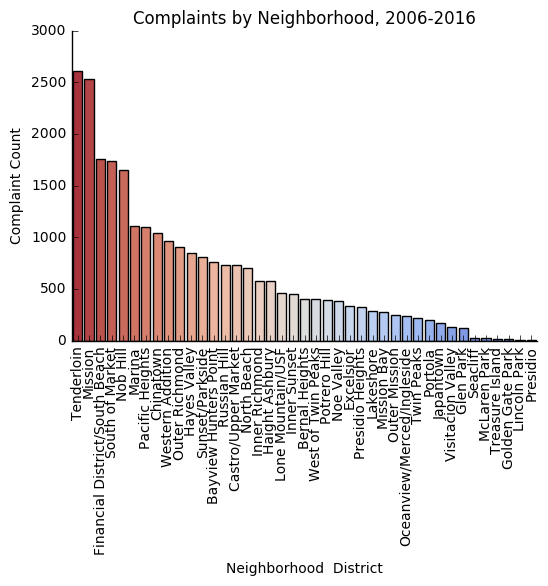

In [3]:
#Top complaint districts
t1 = topcom(complaint_df, 'Neighborhood  District')
t1.rename(columns = {'Count': 'Complaint Count'}, inplace=True)
my_barplot('Neighborhood  District', 'Complaint Count', t1, 'Complaints by Neighborhood, 2006-2016')


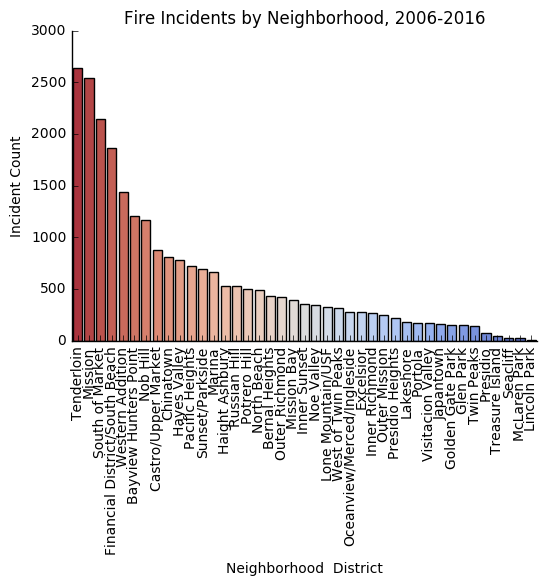

In [4]:
#Top incident districts
t2 = topcom(incident_df, 'Neighborhood  District')
t2.rename(columns = {'Count': 'Incident Count'}, inplace=True)
my_barplot('Neighborhood  District', 'Incident Count', t2, 'Fire Incidents by Neighborhood, 2006-2016')


C:\Users\Kevin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


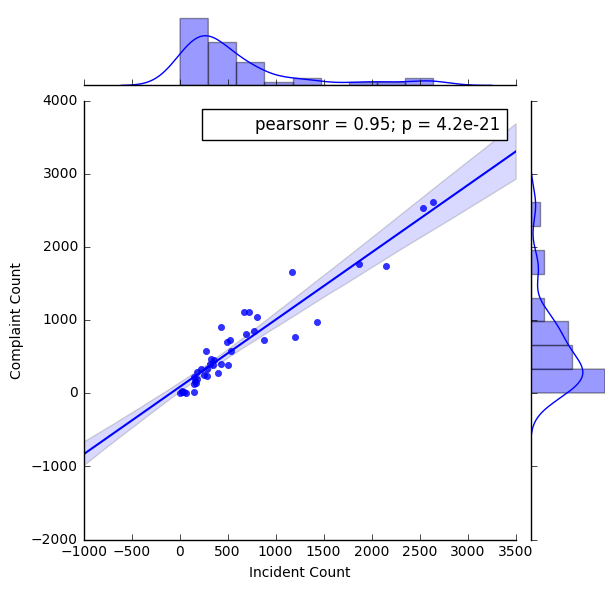

In [5]:
#Relationship b/w incidents and complaints
mrg_dta = pd.merge(t1, t2, on='Neighborhood  District')
sns.jointplot(x='Incident Count',y='Complaint Count',data=mrg_dta,kind='reg')


## Relationship between incidents and complaints at EAS level
Instead of grouping incidents/complaints at the neighborhood level, I create another dataset that pairs incidents to complaints (b/w 2006-2016) at the EAS level.  I also create simple "incident_dummy" and "complaint_dummy" variables to represent whether an EAS has had one (or more) incidents/complaints in the last 10 years.

The takeaway here appears to be the opposite of what we saw in the neighborhood-level data.  There is actually a fairly strong negative correlation between complaints and incidents (especially when looking at dummy var correlation).

I also run a simple probit model with incident_dummy as the dependent var and complaint count on the RHS.  The resulting coefficient on complaint counts is negative and significant, implying a diminishing probability of a fire incident if a complaint is issued.  Likely, the reasoning is that fire complaints are preemptive and actually prevent fires from occuring! 

In [6]:
#Now, does this relationship hold at EAS level?  Lets see...
t3 = topcom(incident_df, 'EAS')
t3.rename(columns = {'Count': 'incident_count'}, inplace=True)
t3['incident_dummy'] = 1

t4 = topcom(complaint_df, 'EAS')
t4.rename(columns = {'Count': 'complaint_count'}, inplace=True)
t4['complaint_dummy'] = 1

mrg_dta2 = pd.merge(t3, t4, on='EAS', how='outer')
mrg_dta2 = mrg_dta2.fillna(0)
mrg_dta2.corr()

,incident_count,EAS,incident_dummy,complaint_count,complaint_dummy
incident_count,1.000000,0.012335,0.355772,0.056120,-0.184034
EAS,0.012335,1.000000,-0.027126,-0.026660,-0.059619
incident_dummy,0.355772,-0.027126,1.000000,-0.275740,-0.750936
complaint_count,0.056120,-0.026660,-0.275740,1.000000,0.518402
complaint_dummy,-0.184034,-0.059619,-0.750936,0.518402,1.000000


In [7]:
#Probit model fire incident dummy on number of complaints
f = 'incident_dummy ~ complaint_count'
incident_dummy, X = patsy.dmatrices(f, mrg_dta2, return_type='dataframe')
sm.Probit(incident_dummy, X).fit().summary()

Optimization terminated successfully.
         Current function value: 0.643670
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:         incident_dummy   No. Observations:                18884
Model:                         Probit   Df Residuals:                    18882
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Aug 2017   Pseudo R-squ.:                 0.05594
Time:                        12:59:06   Log-Likelihood:                -12155.
converged:                       True   LL-Null:                       -12875.
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.4080      0.011     36.875      0.000         0.386     0.430
complaint_count    -0.1507      0.004    -37.315      0.000        -0.159    -0.143
===================================================================================
"""